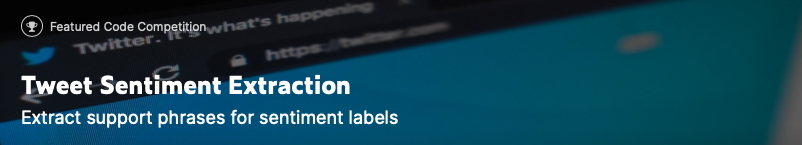

1. This notebook is the variation of Chris Deotte's [Tensorflow Roberta](https://www.kaggle.com/cdeotte/tensorflow-roberta-0-705) where I converted the code to TPU following this [discussion](https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/143869)
1. This notebook covers the inference part of the Tweet Sentiment Extraction test dataset. Please follow this [(Training) kernel](https://www.kaggle.com/meenakshiramaswamy/tweet-sentiment-roberta-tpu-inference) to check the training part with multiple folds.
1. I have used the Pretrained Roberta model and vocab file that are downloaded by  [Chris Deotte](https://www.kaggle.com/cdeotte/tf-roberta)
1. Here's the link to the trained multiple fold weights  [dataset](https://www.kaggle.com/meenakshiramaswamy/v18robertaweights)





### Reference kernels
> [Chris Deotte's Tensorflow Roberta](https://www.kaggle.com/cdeotte/tensorflow-roberta-0-705)

> [Discussion Forums](https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/143281)

### highest score CV .703   LB 0.711
> Training version 20 :
> seed 42, optimizer = adam,  lr = 3e-5  , loss = 'categorical_crossentropy'
> 

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
test_df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')

In [ ]:
os.listdir('/kaggle/input')
model_path = '../input/tf-roberta/'
weights_path = '../input/tfrobertaweights/tf_roBERTa-weights/'

In [ ]:
weights_list = []
weights_list = list(os.listdir(weights_path))
#weights_list

In [ ]:
weights_path_latest = '../input/v18robertaweights/'#'../input/tweet-sentiment-roberta-tpu-version/'
weights_path_latest_list = []
for root, dirs, files in os.walk(weights_path_latest):
    for file in files:
        if file.endswith(".h5"):
             #print(os.path.join(root, file))
            weights_path_latest_list.append(file)

In [ ]:
#weights_list
#weights_list=pd.concat ( pd.DataFrame(weights_path_latest_list))
#weights_list


In [ ]:
#weights_path_latest_list = list(os.listdir(weights_path_latest))
#weights_list.append (weights_path_latest_list)
#weights_list.sort()
#print (weights_path_latest_list)

In [ ]:
import tensorflow as tf
from transformers import *
import tokenizers
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
print('TF version',tf.__version__)

In [ ]:
MAX_LEN = 96

tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab_file=model_path+'vocab-roberta-base.json', 
    merges_file=model_path+'merges-roberta-base.txt', 
    lowercase=True,
    add_prefix_space=True
)
sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}

In [ ]:
ct = test_df.shape[0]
input_ids_t = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask_t = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids_t = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(test_df.shape[0]):
        
    # INPUT_IDS
    text1 = " "+" ".join(test_df.loc[k,'text'].split())
    enc = tokenizer.encode(text1)                
    s_tok = sentiment_id[test_df.loc[k,'sentiment']]
    input_ids_t[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask_t[k,:len(enc.ids)+5] = 1

In [ ]:
def build_model():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)

    config = RobertaConfig.from_pretrained(model_path+'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(model_path+'pretrained-roberta-base.h5',config=config)
    x = bert_model(ids,attention_mask=att,token_type_ids=tok)
    
    x1 = tf.keras.layers.Dropout(0.15)(x[0]) 
    #x1 = tf.keras.layers.Conv1D(1,1)(x1)
    #x1 =  tf.keras.layers.Conv1D(2048,2, padding='same')(x1)
    #x1 =  tf.keras.layers.Conv1D(1024,2, padding='same')(x1)
    x1 =  tf.keras.layers.Conv1D(512,2, padding='same')(x1)
    x1 = tf.keras.layers.Conv1D(256, 2,padding='same')(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)
    
    x2 = tf.keras.layers.Dropout(0.15)(x[0]) 
    #x2 = tf.keras.layers.Conv1D(1,1)(x2)
    #x2 =  tf.keras.layers.Conv1D(2048,2, padding='same')(x2)
    #x2 =  tf.keras.layers.Conv1D(1024,2, padding='same')(x2)
    x2 =  tf.keras.layers.Conv1D(512,2, padding='same')(x2)
    x2 = tf.keras.layers.Conv1D(256, 2,padding='same')(x2)
    x2 = tf.keras.layers.Dense(1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)

    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)

    return model

In [ ]:
#for i, fl in enumerate(weights_list):
#    print  (weights_list[i])
for i, fl in enumerate(weights_path_latest_list):
    print  (weights_path_latest_list[i])

In [ ]:
#VER = 'v18-fd'
preds_start = np.zeros((input_ids_t.shape[0],MAX_LEN))
preds_end = np.zeros((input_ids_t.shape[0],MAX_LEN))
for i, fl in enumerate(weights_path_latest_list):
    
    K.clear_session()
    
    model = build_model()
        
    print('Loading model...')
    #model.load_weights(weights_path + 'v13-fd%i-roberta-wt.h5'%(i+1))
    model.load_weights(weights_path_latest + weights_path_latest_list[i])    
    print(f'Predicting Test...using weights...{weights_path_latest_list[i]}')
    preds = model.predict([input_ids_t,attention_mask_t,token_type_ids_t],verbose=1)
    preds_start += preds[0]/len(weights_path_latest_list)
    preds_end += preds[1]/len(weights_path_latest_list)

In [ ]:
'''
#VER = 'v13-fd'
preds_start = np.zeros((input_ids_t.shape[0],MAX_LEN))
preds_end = np.zeros((input_ids_t.shape[0],MAX_LEN))
for i, fl in enumerate(weights_list):
    
    K.clear_session()
    
    model = build_model()
        
    print('Loading model...')
    #model.load_weights(weights_path + 'v13-fd%i-roberta-wt.h5'%(i+1))
    model.load_weights(weights_path + weights_list[i])    
    print(f'Predicting Test...using weights...{weights_list[i]}')
    preds = model.predict([input_ids_t,attention_mask_t,token_type_ids_t],verbose=1)
    preds_start += preds[0]/len(weights_list)
    preds_end += preds[1]/len(weights_list)
'''

In [ ]:
submission = []
for i in range(input_ids_t.shape[0]):
    a = np.argmax(preds_start[i,])
    b = np.argmax(preds_end[i,])
    if a>b: 
        st = test_df.loc[i,'text']
    else:
        text1 = " "+" ".join(test_df.loc[i,'text'].split())
        enc = tokenizer.encode(text1)
        st = tokenizer.decode(enc.ids[a-1:b])
    submission.append(st)


In [ ]:
test_df['selected_text'] = submission
pd.set_option('max_colwidth', 50)


In [ ]:
submission_df = test_df[['textID','selected_text']]
submission_df.sample(25)

In [ ]:
submission_df.to_csv('submission.csv',index=False)
print ('Submitted Successfully.....')